<a href="https://colab.research.google.com/github/Ashrafalaghbari/Mutivariate-long-term-forecasting-of-oil-production/blob/main/multivariate_model_multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 60

Autosaving every 60 seconds


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# check if GPU is utilized 
device_name = tf.config.experimental.list_physical_devices()[-1][-1]
if device_name != 'GPU':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

SystemError: ignored

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [ ]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #adjusted MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2* result/ len(actual) 
    return result * 100

In [ ]:
colum = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv')
colum.columns

In [ ]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv',
                     usecols=["DATEPRD",'AVG_CHOKE_SIZE_P','AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE',
                              'ON_STREAM_HRS','AVG_WHP_P','AVG_WHT_P','F_4_BORE_WI_VOL','F_5_BORE_WI_VOL',
                              'DP_CHOKE_SIZE', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
                              "BORE_OIL_VOL"],
                  parse_dates=["DATEPRD"], index_col="DATEPRD")
#change the order of BORE_OIL_VOL
# series =series[["ON_STREAM_HRS",'BORE_GAS_VOL', 'BORE_WAT_VOL','AVG_CHOKE_SIZE_P','F_4_BORE_WI_VOL','F_5_BORE_WI_VOL',
                # "BORE_OIL_VOL"]] # chan

In [ ]:
recovery_time  = pd.Series(series.index.values).diff()
recovery_time = recovery_time.fillna(pd.Timedelta(days=1))
recovery_time = recovery_time.astype('string')
recovery_time  = recovery_time.str.extract(r'(\d+)')
recovery_time.index = series.index.values
series['recovery_time']  = recovery_time.astype('int')
series['recovery_time'] = series['recovery_time'] - 1

In [ ]:
series["next_choke_size"] = series['AVG_CHOKE_SIZE_P'].shift(-1).fillna(0)
series["next_on_stream"] = series['ON_STREAM_HRS'].shift(-1).fillna(0)

In [ ]:
column_to_move = series.pop("BORE_OIL_VOL")

# insert column with insert(location, column_name, column_value)

series.insert(len(series.columns), "BORE_OIL_VOL", column_to_move)

In [ ]:
series.shape

(1844, 12)

In [ ]:
series

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_GAS_VOL,BORE_WAT_VOL,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,BORE_OIL_VOL,choke_size(t+1)
DATEPRD,,,,,,,,,,,,,
2010-01-01,24.0,3378.643673,223.079164,50.150825,749.568621,190.264943,271.390953,1.462166e+07,15304.241356,44109.287732,49054.221066,18593.749401,50.694654
2010-01-02,24.0,3377.769461,223.095696,50.694654,744.664780,190.708397,266.368677,1.469266e+07,16519.118273,41936.969541,51515.296516,18701.242265,47.665676
2010-01-03,24.0,3408.561097,223.074953,47.665676,774.827418,192.268341,299.398157,1.400904e+07,14796.150455,41114.572918,51717.286427,17799.912406,44.706230
2010-01-04,24.0,3439.266918,223.022721,44.706230,806.160543,191.994925,333.246980,1.341015e+07,13428.619835,40267.292699,51948.640243,17002.616014,45.743761
2010-01-05,24.0,3429.064568,223.035833,45.743761,792.735696,191.503603,318.470614,1.361768e+07,9839.905499,40524.238503,52129.744099,17270.939334,46.053981
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,24.0,3847.013385,211.367931,100.000000,446.876829,190.761010,32.394472,1.366424e+06,21779.601368,27765.068530,26704.126695,1662.711432,100.000000
2015-03-20,24.0,3846.666639,211.352287,100.000000,446.242576,190.577844,31.563179,1.397308e+06,23586.538158,26112.632371,27951.162219,1707.494884,100.000000
2015-03-21,24.0,3846.286199,211.349048,100.000000,446.048129,191.111429,31.526865,1.408435e+06,22172.777429,26281.191015,27980.731217,1725.420844,100.000000


In [ ]:
series.corr().iloc[:,-1] #200

ON_STREAM_HRS               0.429017
AVG_DOWNHOLE_PRESSURE      -0.514724
AVG_DOWNHOLE_TEMPERATURE    0.918395
AVG_CHOKE_SIZE_P           -0.067340
AVG_WHP_P                   0.247035
AVG_WHT_P                   0.426416
DP_CHOKE_SIZE               0.048679
BORE_GAS_VOL                0.996707
BORE_WAT_VOL                0.290599
F_4_BORE_WI_VOL             0.516457
F_5_BORE_WI_VOL             0.582626
BORE_OIL_VOL                1.000000
Name: BORE_OIL_VOL, dtype: float64

In [ ]:
# Data visulaization and disribution plots for well F-14 after including the injectors
data = series.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 28))

axs = axs.ravel()

for id, column in enumerate(data):

    axs[id].plot(series[column])
    axs[id].grid(True)
    axs[id].legend([column], loc='lower left', fontsize=9, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

**Multi-output forecasting strategy**

In [ ]:
# # # convert series to stationary 
series_diff = series.copy()
# diff_order = 1
# series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)
# # convert the stationary series to supervise learning
timesteps = 9 # lag features
steps_ahead = 1
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

In [ ]:
series.iloc[2:4]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_GAS_VOL,BORE_WAT_VOL,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,next_choke_size,next_on_stream,BORE_OIL_VOL
DATEPRD,,,,,,,,,,,,,,
2010-01-03,24.0,3408.561097,223.074953,47.665676,774.827418,192.268341,299.398157,1.400904e+07,14796.150455,41114.572918,51717.286427,44.706230,24.0,17799.912406
2010-01-04,24.0,3439.266918,223.022721,44.706230,806.160543,191.994925,333.246980,1.341015e+07,13428.619835,40267.292699,51948.640243,45.743761,24.0,17002.616014


In [ ]:
series.loc[series['ON_STREAM_HRS']==0]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_GAS_VOL,BORE_WAT_VOL,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,next_choke_size,next_on_stream,BORE_OIL_VOL
DATEPRD,,,,,,,,,,,,,,
2010-04-01,0.0,3927.602959,218.937457,0.0,805.302507,109.717783,278.732567,0.0,0.0,15655.338583,9717.757377,35.256447,9.14166,0.0
2010-08-17,0.0,4254.753548,216.167018,0.0,44.365014,82.606262,17.506635,0.0,0.0,0.000000,24883.763848,0.000000,0.00000,0.0
2010-08-20,0.0,4315.500139,213.801260,0.0,55.442416,59.311400,43.355841,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0
2010-08-21,0.0,4379.142263,213.661328,0.0,45.440178,60.809594,33.551870,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0
2010-08-22,0.0,4378.296838,213.412298,0.0,33.060337,60.046358,21.511562,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-20,0.0,4381.566569,209.783804,0.0,4.962176,57.901712,3.597226,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0
2014-08-21,0.0,4386.874080,210.091874,0.0,5.142458,67.619282,0.914898,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0
2014-08-22,0.0,4386.874080,210.091874,0.0,5.142458,67.619282,0.914898,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0


In [ ]:
# pd.set_option('display.max_columns', None)
series_supervised.loc[series_supervised['next_on_stream(t-1)']==0]

,ON_STREAM_HRS(t-2),AVG_DOWNHOLE_PRESSURE(t-2),AVG_DOWNHOLE_TEMPERATURE(t-2),AVG_CHOKE_SIZE_P(t-2),AVG_WHP_P(t-2),AVG_WHT_P(t-2),DP_CHOKE_SIZE(t-2),BORE_GAS_VOL(t-2),BORE_WAT_VOL(t-2),F_4_BORE_WI_VOL(t-2),...,AVG_WHT_P(t-1),DP_CHOKE_SIZE(t-1),BORE_GAS_VOL(t-1),BORE_WAT_VOL(t-1),F_4_BORE_WI_VOL(t-1),F_5_BORE_WI_VOL(t-1),next_choke_size(t-1),next_on_stream(t-1),BORE_OIL_VOL(t-1),BORE_OIL_VOL(t)
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2010-04-01,24.00000,3512.480745,223.447836,45.174481,808.542996,190.219326,324.428882,1.285337e+07,16082.794112,52979.604853,...,189.350904,324.138434,1.272020e+07,17399.754655,53364.146204,50889.352678,0.0,0.0,15913.598207,0.0
2010-08-17,24.00000,3647.527407,223.675728,59.231621,694.322526,200.317251,221.464081,1.186412e+07,22003.770218,40563.073975,...,199.962925,239.155016,1.155754e+07,21382.777218,39495.791300,41199.828827,0.0,0.0,14332.528516,0.0
2010-08-20,23.75833,3661.351033,223.661588,57.292090,708.182515,199.962925,239.155016,1.155754e+07,21382.777218,39495.791300,...,82.606262,17.506635,0.000000e+00,0.000000,0.000000,24883.763848,0.0,0.0,0.000000,0.0
2010-08-21,0.00000,4254.753548,216.167018,0.000000,44.365014,82.606262,17.506635,0.000000e+00,0.000000,0.000000,...,59.311400,43.355841,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
2010-08-22,0.00000,4315.500139,213.801260,0.000000,55.442416,59.311400,43.355841,0.000000e+00,0.000000,0.000000,...,60.809594,33.551870,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-20,24.00000,3781.168805,211.778591,100.000000,449.919210,191.795590,30.343765,1.795857e+06,22139.881720,44470.398313,...,190.334435,88.045730,3.637729e+04,350.342450,8189.321139,9637.788218,0.0,0.0,27.046186,0.0
2014-08-21,1.65833,3853.902665,211.796573,11.011189,455.527347,190.334435,88.045730,3.637729e+04,350.342450,8189.321139,...,57.901712,3.597226,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
2014-08-22,0.00000,4381.566569,209.783804,0.000000,4.962176,57.901712,3.597226,0.000000e+00,0.000000,0.000000,...,67.619282,0.914898,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [ ]:
# # time-dependent variables 
# shifted_ON_STREAM_HRS = series_diff["ON_STREAM_HRS"].shift(-(timesteps + diff_order)).dropna()
# shifted_ON_STREAM_HRS.index = series_supervised.index.values 
# shifted_AVG_CHOKE_SIZE_P = series_diff['AVG_CHOKE_SIZE_P'].shift(-(timesteps + diff_order)).dropna()
# shifted_AVG_CHOKE_SIZE_P.index = series_supervised.index.values
# series_supervised = pd.concat([shifted_ON_STREAM_HRS,shifted_AVG_CHOKE_SIZE_P, series_supervised], axis=1) 

In [ ]:
# #drop all the variables that we don't want to predict
# vars_y = series_supervised.columns[-steps_ahead*len(series.columns):]
# vars_name_to_drop = ['ON_STREAM_HRS(t+)']
# vars_to_drop = vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
# series_supervised.drop(columns=vars_to_drop, inplace=True)

In [ ]:
# # bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
# ON_STREAM_HRS_t = series_supervised.pop('ON_STREAM_HRS(t)')
# series_supervised.insert(len(series_supervised.columns)-1, 'ON_STREAM_HRS(t)', ON_STREAM_HRS_t)

In [ ]:
merged_onStreams = series_supervised["ON_STREAM_HRS(t-1)"] + (series_supervised["ON_STREAM_HRS(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_onStreams', merged_onStreams)

In [ ]:
merged_choke = series_supervised["AVG_CHOKE_SIZE_P(t-1)"] + (series_supervised["AVG_CHOKE_SIZE_P(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_choke', merged_choke)

In [ ]:
merged_WI_F_4 = series_supervised["F_4_BORE_WI_VOL(t-1)"] + (series_supervised["F_4_BORE_WI_VOL(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_WI_F_4', merged_WI_F_4)

In [ ]:
merged_WI_F_5 = series_supervised["F_5_BORE_WI_VOL(t-1)"] + (series_supervised["F_5_BORE_WI_VOL(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_WI_F_5', merged_WI_F_5)

In [ ]:
series_supervised.drop(['ON_STREAM_HRS(t-1)', 'AVG_CHOKE_SIZE_P(t-1)',"F_4_BORE_WI_VOL(t-1)",
                        "F_5_BORE_WI_VOL(t-1)"], axis=1, inplace= True)

In [ ]:
series_supervised.drop(['AVG_CHOKE_SIZE_P(t)','ON_STREAM_HRS(t)','AVG_DOWNHOLE_PRESSURE(t)', 'AVG_DOWNHOLE_TEMPERATURE(t)',
                        'F_4_BORE_WI_VOL(t)','AVG_WHP_P(t)', 'AVG_WHT_P(t)', 'DP_CHOKE_SIZE(t)', "next_on_stream(t)", "next_choke_size(t)",
                        'F_5_BORE_WI_VOL(t)', 'BORE_GAS_VOL(t)', 'BORE_WAT_VOL(t)'], axis=1, inplace= True)


In [ ]:
# # split into train and test sets
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print(train.shape, test.shape)

(1468, 127) (367, 127)


In [ ]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape, test_scaled.shape)

(1468, 127) (367, 127)


In [ ]:
# # reshape input to be 3D [samples, timesteps, features]
n_features = len(series.columns) 

train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1468, 9, 14) (1468, 1) (367, 9, 14) (367, 1)


In [ ]:
# Create a new directory in My Drive
directory = '/content/drive/My Drive/my_trained_models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [12]#12 
n_epochs=700#186

model = Sequential()
model.add(LSTM(neurons[0], activation="tanh", input_shape=(timesteps, n_features)))
model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# # early stopping to return the best model
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2, restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min') 

# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()

# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=2, validation_data=(test_X, test_y), verbose=2,
                     shuffle=False)
    # to find at which epoch each loss is
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 10 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

Epoch 1/700
734/734 - 5s - loss: 0.0204 - val_loss: 0.0073 - 5s/epoch - 6ms/step
Epoch 2/700
734/734 - 3s - loss: 0.0266 - val_loss: 0.0063 - 3s/epoch - 4ms/step
Epoch 3/700
734/734 - 3s - loss: 0.0227 - val_loss: 0.0054 - 3s/epoch - 4ms/step
Epoch 4/700
734/734 - 3s - loss: 0.0194 - val_loss: 0.0047 - 3s/epoch - 4ms/step
Epoch 5/700
734/734 - 3s - loss: 0.0166 - val_loss: 0.0043 - 3s/epoch - 4ms/step
Epoch 6/700
734/734 - 3s - loss: 0.0143 - val_loss: 0.0041 - 3s/epoch - 4ms/step
Epoch 7/700
734/734 - 3s - loss: 0.0123 - val_loss: 0.0041 - 3s/epoch - 4ms/step
Epoch 8/700
734/734 - 3s - loss: 0.0106 - val_loss: 0.0041 - 3s/epoch - 4ms/step
Epoch 9/700
734/734 - 3s - loss: 0.0091 - val_loss: 0.0043 - 3s/epoch - 4ms/step
Epoch 10/700
734/734 - 3s - loss: 0.0079 - val_loss: 0.0045 - 3s/epoch - 4ms/step
Epoch 11/700
734/734 - 3s - loss: 0.0069 - val_loss: 0.0048 - 3s/epoch - 4ms/step
Epoch 12/700
734/734 - 3s - loss: 0.0062 - val_loss: 0.0051 - 3s/epoch - 4ms/step
Epoch 13/700
734/734 - 3s

In [ ]:
# load the trained saved model
model_saved = tf.keras.models.load_model('/content/drive/My Drive/my_trained_models/model_20Eps.h5')

In [ ]:
# Load the best weights
model.load_weights(f'.mdl_wts.hdf5')

In [ ]:
score = model.evaluate(test_X, test_y, verbose=0)
best_epoch = loss_tracking.index(score) + 1
# validation loss and corresponding epoch for the saved model
print(f'Epoch:{best_epoch} Validation loss: {score}') 

Epoch:509 Validation loss: 0.00018703137175180018


In [ ]:
# # if training is interrupted 
# n_epochs = 700 - best_epoch # to continue from which epoch it was stopped
# # Run the training loop
# for epoch in range(initial_epoch , n_epochs+1):
#     print(f'Epoch {epoch}/{n_epochs}')
#     # Train the model for one epoch
#     history = model_saved.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
#                     epochs=1, batch_size=2, validation_data=(test_X, test_y), verbose=2,
#                      shuffle=False)
#     # to find at which epoch each loss is
#     validation_loss= model_saved.evaluate(test_X, test_y, verbose=0)
#     loss_tracking.append(validation_loss)
#     # Save the model every 10 epochs
#     if epoch % 10 == 0:
#         # Save the model  in HDF5 foramt with a filename that includes the epoch number
#         model_saved.save(f'model_{epoch}Eps.h5')

In [ ]:
# 2.455e-04 all variables 6 times steps
# 4.2105e-04 all variables 4 times steps
# all variables 9 time steps 1.870e-04

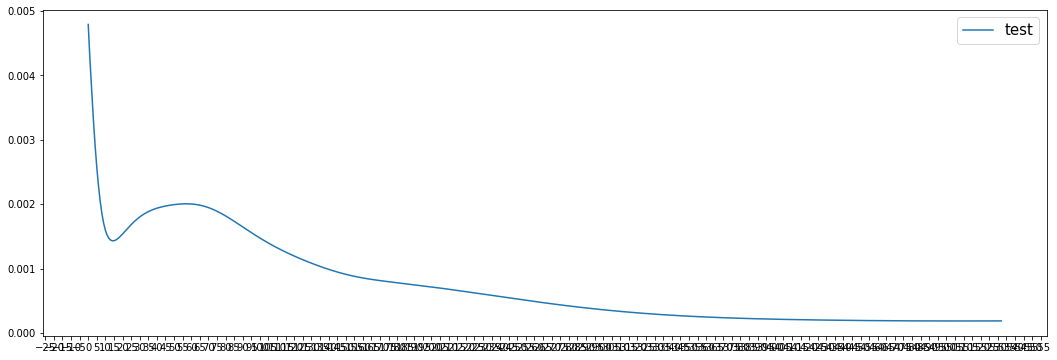

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#plt.plot(history.history['loss'], label='train')
plt.plot( loss_tracking, label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [ ]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:], verbose=1)


# invert scaling 
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat.ravel()) ## ravel () converting into 1D array
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
inv_scale_y = scaled_y.apply(transform_column, axis=0)
inv_scale_y = inv_scale_y.values.ravel() 
# invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)
inv_scale_yhat = inv_scale_yhat.values.ravel()

12/12 [==============================] - 1s 3ms/step


In [ ]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1,0]
#drop all the variables that we don't want to predict
#agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [ ]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt) as explained above
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

current_timestep = 1
# actual value of oil rate at current time step
# steps_ahead = 4
#drop all the variables that we don't want to predict
vars_y = originalSeries_supervised.columns[-steps_ahead*len(series.columns):]
vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
originalSeries_supervised.drop(columns=vars_to_drop, inplace=True)
originalSeries_xt = originalSeries_supervised.iloc[-len(test):,-steps_ahead-2]


# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
#inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)
inv_yhat_cum = inv_scale_yhat

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].ravel()[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
#col = pd.DataFrame.from_records(col) # creates a DataFrame from a list of records
col = pd.DataFrame(col)
#col.columns = pd.RangeIndex(start=1, stop=steps_ahead+1, step=1)
inv_yhat = col.values.ravel() # convert df to NumpyArray

In [ ]:
inv_yhat = np.add(inv_scale_yhat,agg)

In [ ]:
inv_y[:10]

array([1902.73060461, 2717.82716026,  672.44365125,   61.70304199,
       3062.1313925 , 1036.43499067, 2522.33984681,  885.22794384,
       3063.89253947, 3337.49930057])

In [ ]:
inv_yhat[:10] 

array([2164.42402892, 3171.03431554,  857.81251182,  362.32646375,
       3367.9969873 , 1618.67533782, 3242.31682661, 1717.44726869,
       3491.30704541, 3167.62691447])

In [ ]:
inv_yhat[:10] 

array([3607.93342036, 2350.85371642, 3257.16322179, 1183.83887901,
        126.939745  , 3499.08097167, 1843.84037688, 3750.63127973,
       1881.272464  , 3321.59024853])

In [ ]:
inv_yhat[:10] 

array([3590.59357661, 2211.30977111, 3251.55189367, 1095.77833214,
        381.24345593, 3312.50870605, 1757.93412688, 3445.83049848,
       1839.522464  , 3686.42227978])

In [ ]:
inv_yhat[:10] 

array([3594.66193598, 2206.2423883 , 3173.63001867, 1143.65919151,
        407.15947156, 3368.39737792, 1757.37943938, 3290.52971723,
       1995.08789369, 3455.65079541])

In [ ]:
inv_yhat[:10] 

array([3626.33967036, 2268.59590392, 3209.46400304, 1201.12501182,
        361.57548718, 3662.83683105, 1867.23881438, 3091.02581098,
       2142.52344056, 3604.08829541])

In [ ]:
inv_yhat[:10] 

array([3434.46857661, 3391.58027892, 1893.50794836, 2708.45704307,
        663.33622937,   53.39640136, 3052.82279875, 1027.26409223,
       2513.01269837,  876.16739697])

In [ ]:
inv_yhat[:10] 

array([3616.66779536, 2901.4142633 , 2707.84290929, 2021.48536339,
        415.11064343, 2041.42862792, 2893.83940032, 1935.12932661,
       2185.30762025, 2642.25040478])

In [ ]:
inv_yhat[:10] 

array([3574.35529536, 2202.53340392, 3130.52064367,  958.16505089,
          4.90165906, 2767.44425292, 1848.91557219, 3947.85198286,
       1786.16992494, 3531.10392041])

In [ ]:
inv_yhat[:10] 

array([3636.01545161, 2339.25898986, 3426.80189367, 1147.14063682,
        288.00908093, 3820.93644042, 2009.1470175 , 3904.13713911,
       1911.25879212, 3662.91837353])

In [ ]:
inv_yhat[:10] # 1 time steps # on stream choke

array([3381.95099848, 1601.08223205, 3568.13392492, -203.34080849,
       -564.89033313, 5612.03995605, 2615.65483   , 3544.03557661,
       1119.57129212, 3880.51602978])

In [ ]:
inv_yhat[:10] # 4 time steps # on stream choke

array([3362.01447504, 3014.15742736, 1575.44740148, 2900.26856651,
        196.33037   ,  969.9657373 , 4537.10893157, 1709.12542036,
       2967.28906556, 1227.26407666])

In [ ]:
inv_yhat[:10]# 4 time steps # on stream

array([3357.58478754, 3198.6486383 , 1894.60365148, 2831.45606651,
        624.30595593,  780.4735498 , 3790.01518157, 1856.40471723,
       3131.147464  , 1301.48477978])

In [ ]:
r2_score(inv_y,inv_yhat)

0.31858047240881304

In [ ]:
wMAPE(inv_y[:10],inv_yhat[:10])

28.446741757485977

In [ ]:
inv_y.shape, inv_yhat.shape

((369,), (369,))

In [ ]:
# Performance evaluation

rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
RMSPE_test = RMSPE(inv_y, inv_yhat)
print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.5f' % MAE_test)
MAPE_test = MAPE(inv_y, inv_yhat)
print('Test MAPE: %.5f' % MAPE_test)
r2 = r2_score(inv_y, inv_yhat)
print('Test r2: %.5f' % r2)
wMAPE_test = wMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % wMAPE_test)
SMAPE_test = SMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % SMAPE_test)

Test RMSE: 449.03130
Test RMSPE: 19544194831094544.00000
Test MAE: 213.63827
Test MAPE: 1353133045674894.00000
Test r2: 0.60894
Test wMAPE: 9.53361 
Test wMAPE: 14.70437 


In [ ]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

IndexError: ignored

In [ ]:
Test RMSE: 555.56135
Test MAE: 277.11301
Test r2: 0.39641
Test wMAPE: 12.32902 
Test SMAPE: 17.45901

In [ ]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

In [ ]:
inv_yhat

In [ ]:
inv_yhat[-1]

In [ ]:
plt.plot(inv_yhat[-1], label = "predicted")
plt.plot(inv_y[-1], label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
#comparing predictions and actual values
act_pred = pd.DataFrame({"actual":inv_y.flatten(), "prediction":inv_yhat.flatten()})
act_pred.head(5)

In [ ]:
series_to_supervised(series, series.columns, n_in=2, n_out=steps_ahead, dropnan=True).iloc[-len(test):-len(test)+5]

In [ ]:
r2_score(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
wMAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
MAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])